In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller


In [3]:
# Read file
data = pd.read_csv("./consumption_temp.csv")
# Convert datatypes
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])
data_cities = {location: data[data["location"] == location] for location in data["location"].unique()}
print(data.columns)


Index(['time', 'location', 'consumption', 'temperature'], dtype='object')


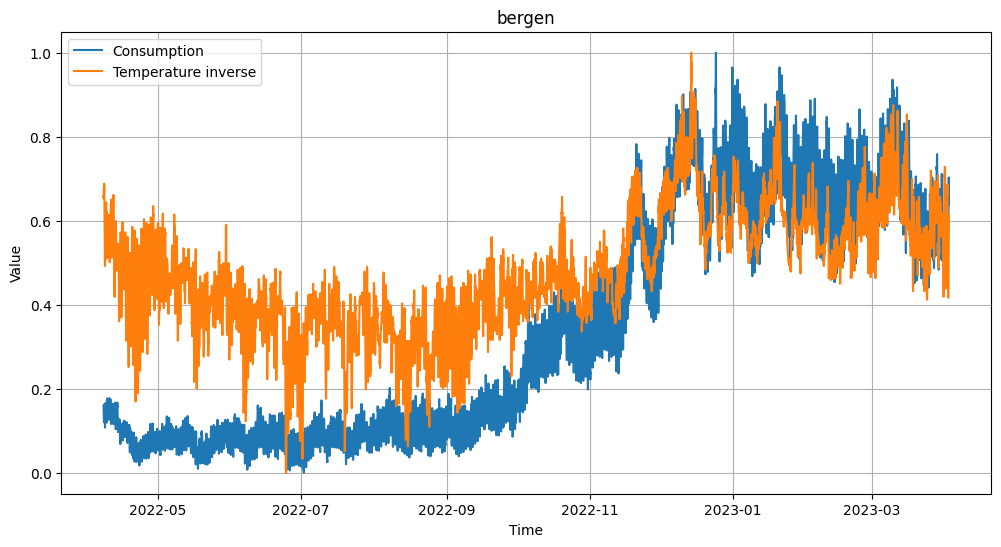

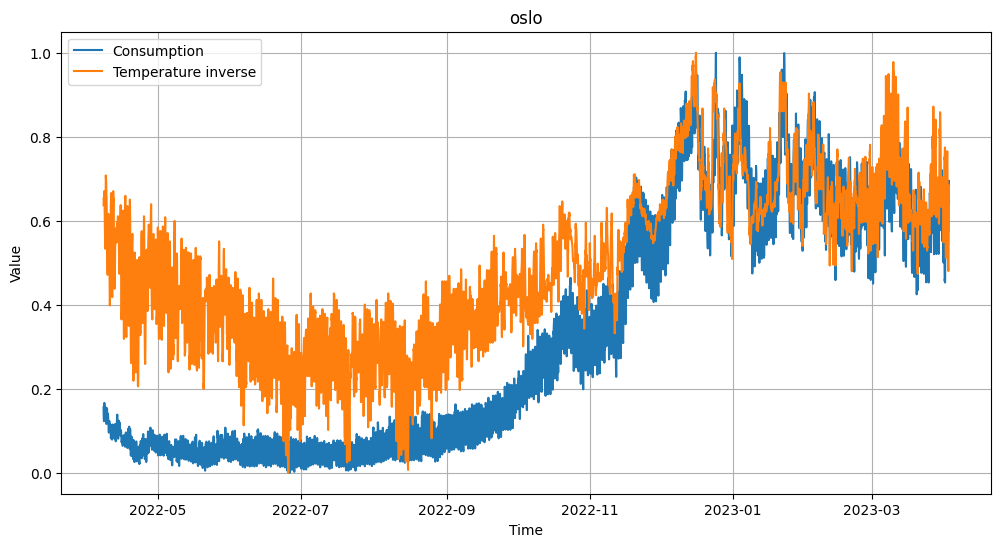

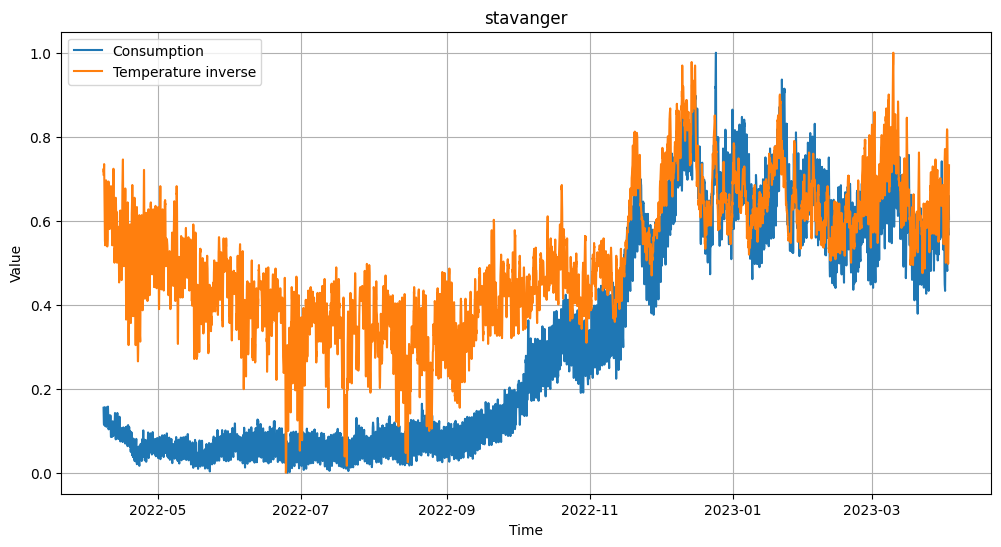

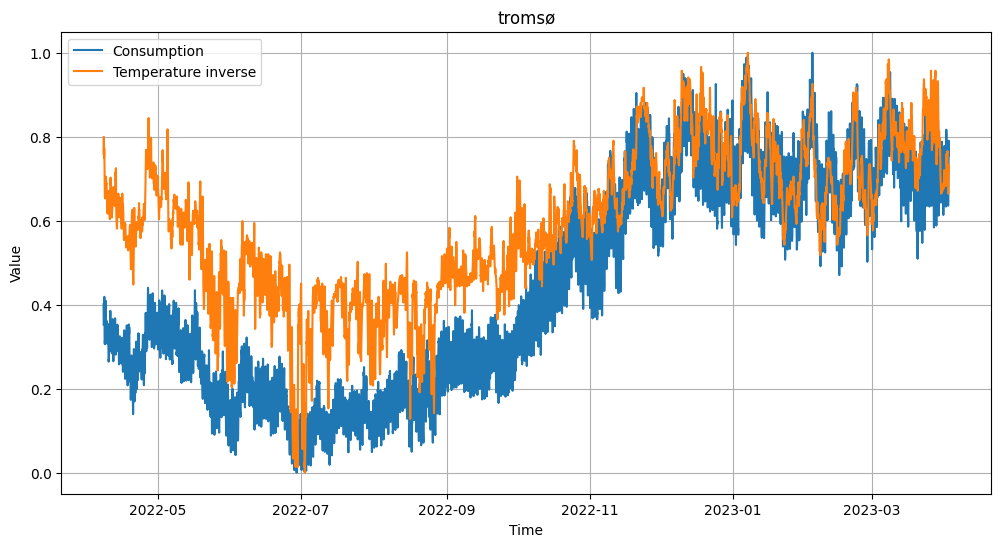

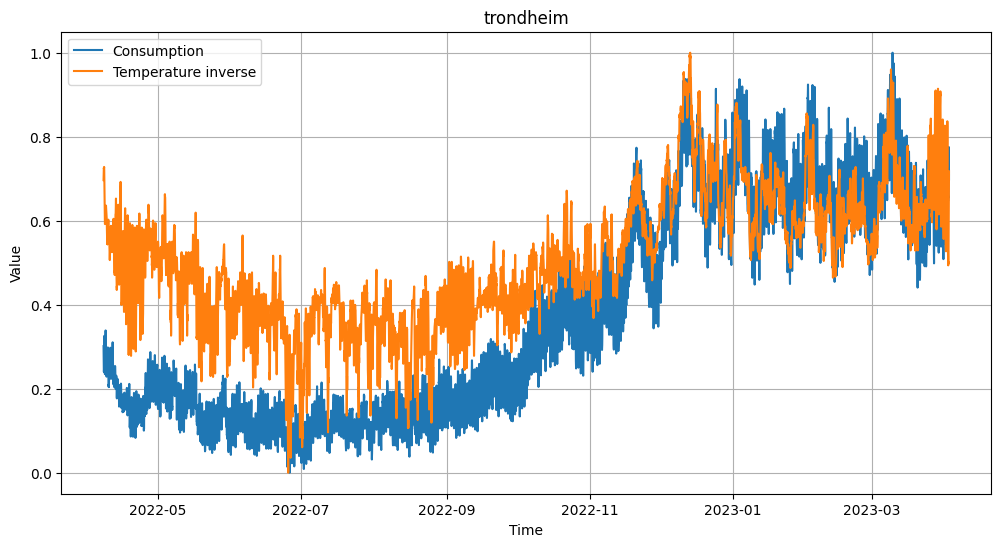

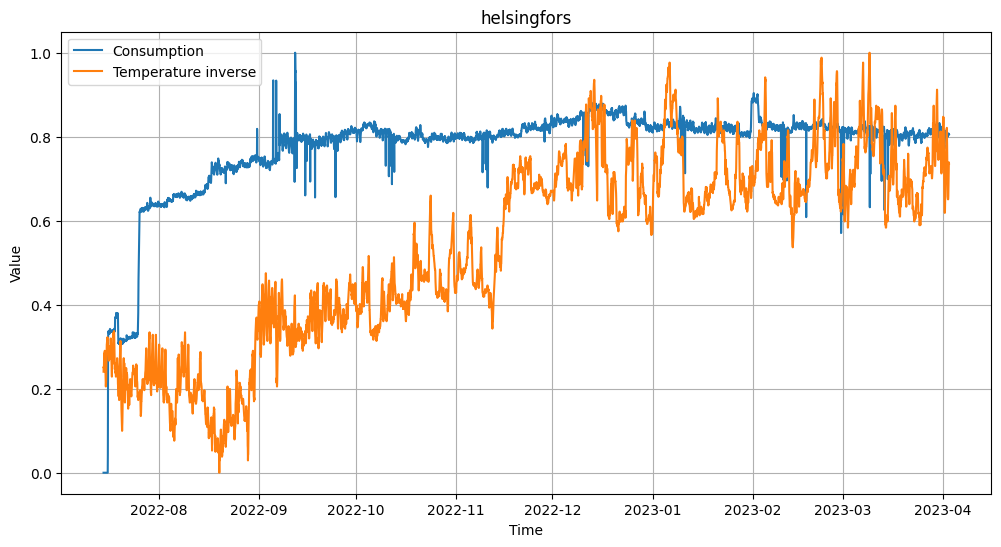

In [4]:
normalize_features = True

# Plot
for city, city_data in data_cities.items():

    # Normalize the "consumption" and "temperature" columns using Min-Max scaling
    min_consumption = city_data['consumption'].min()
    max_consumption = city_data['consumption'].max()
    min_temperature = city_data['temperature'].min()
    max_temperature = city_data['temperature'].max()

    normalized_city_data = city_data.copy()
    if normalize_features:
        normalized_city_data['consumption'] = (city_data['consumption'] - min_consumption) / (max_consumption - min_consumption)
        normalized_city_data['temperature'] = 1 - ((city_data['temperature'] - min_temperature) / (max_temperature - min_temperature))


    # Plot
    plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

    plt.plot(normalized_city_data['time'], normalized_city_data['consumption'], label='Consumption', linestyle='-')
    plt.plot(normalized_city_data['time'], normalized_city_data['temperature'], label='Temperature inverse', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(city)
    plt.legend()
    plt.grid(True)

    plt.show()

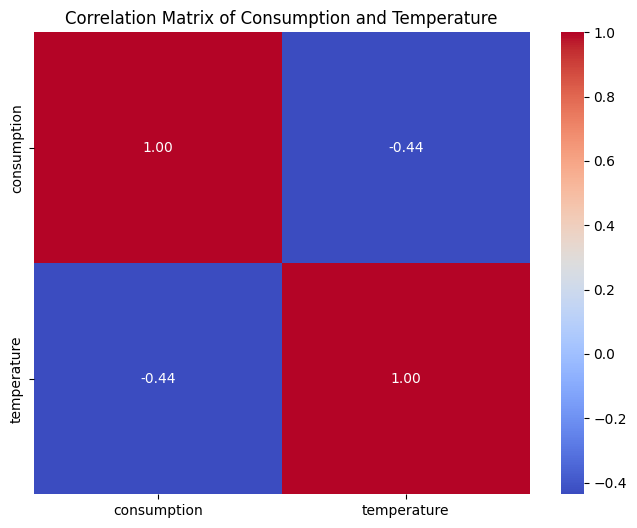

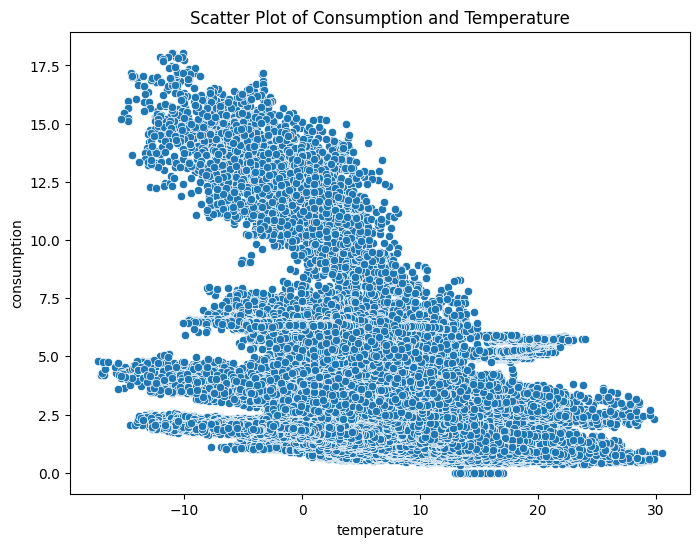

In [5]:

# Calculate the correlation matrix for numerical variables
correlation_matrix = data[['consumption', 'temperature']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Consumption and Temperature')
plt.show()

# Plot the scatter plot between consumption and temperature
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temperature', y='consumption', data=data)
plt.title('Scatter Plot of Consumption and Temperature')
plt.show()




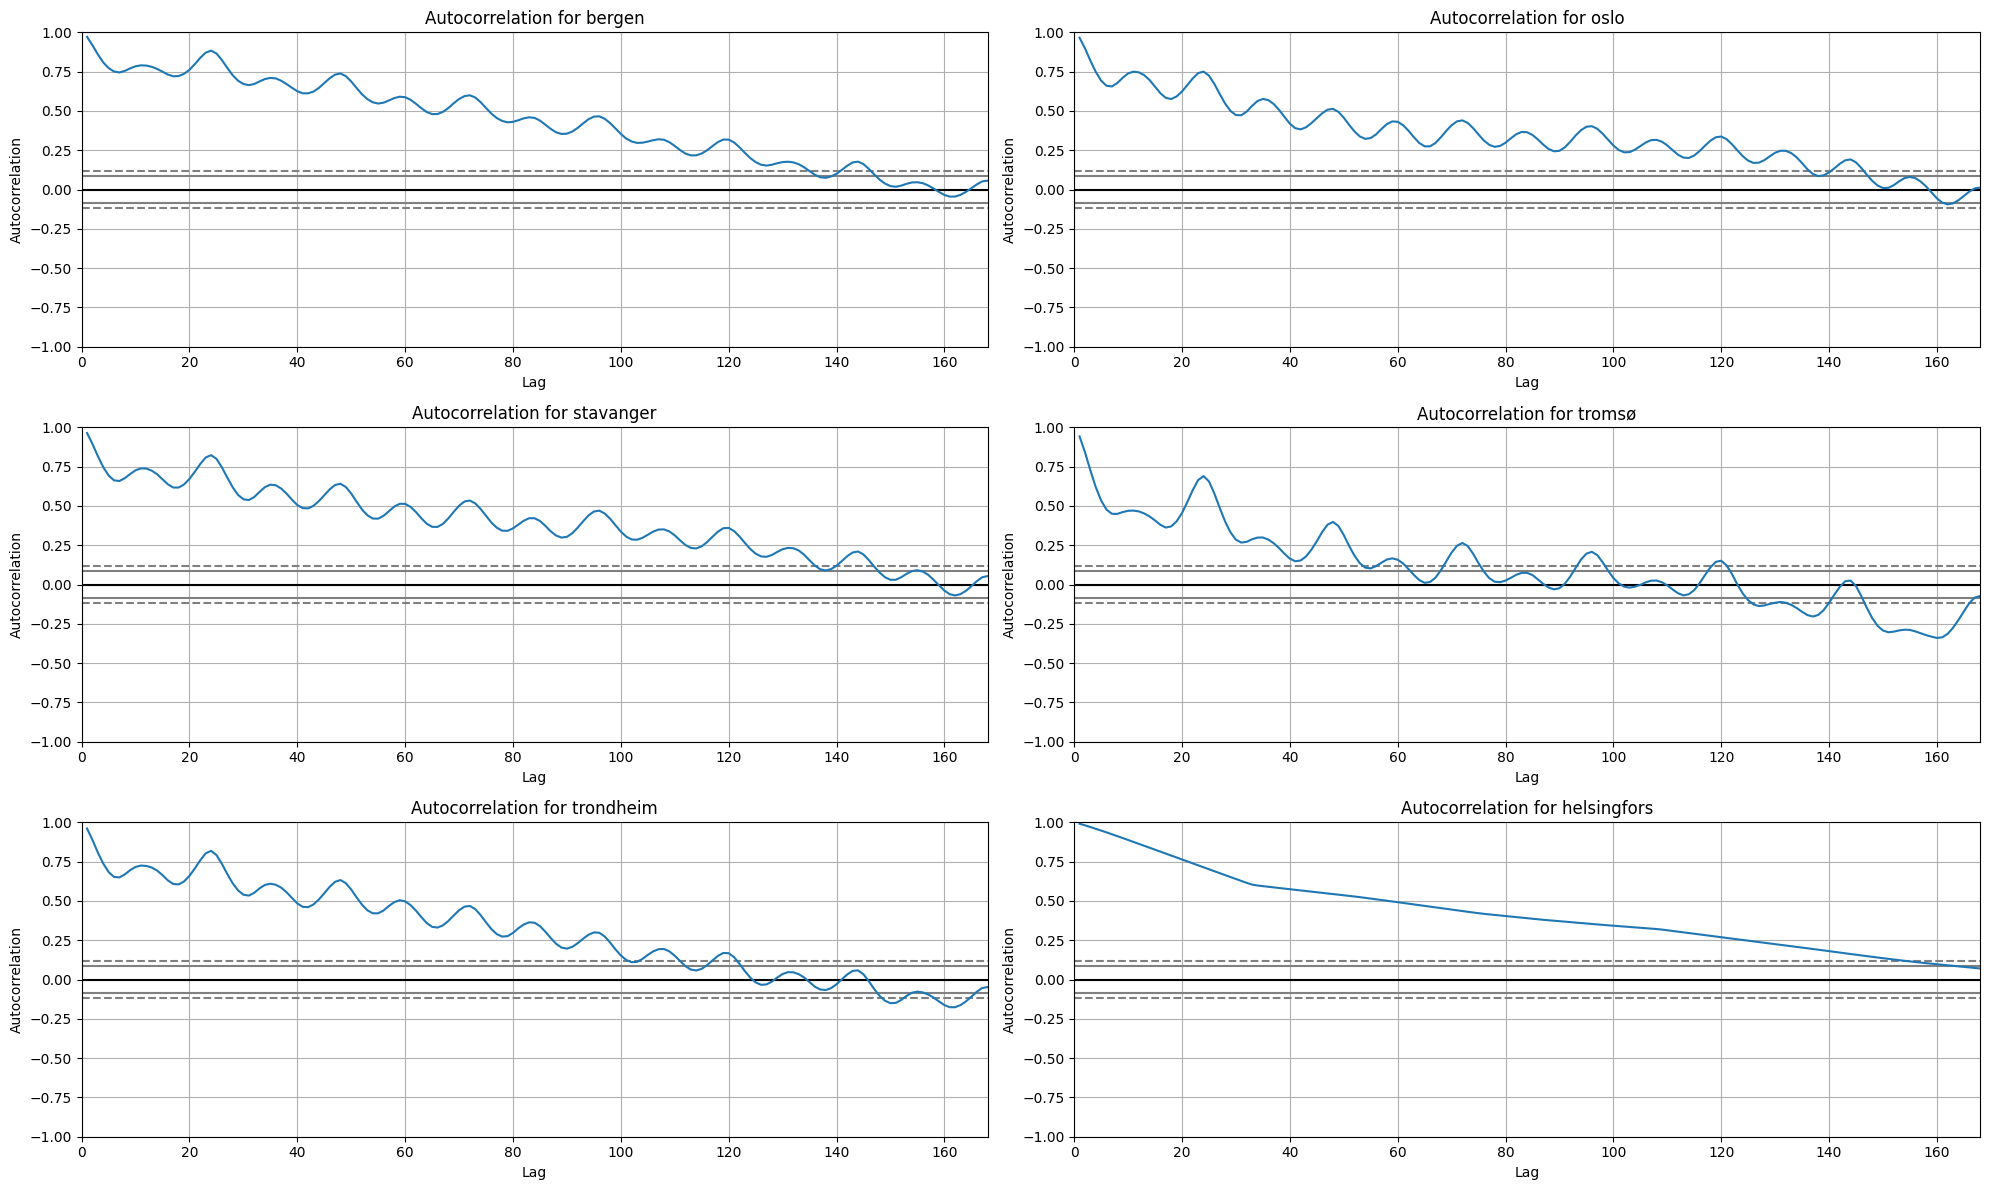

In [15]:
# Initialize a dictionary to store the autocorrelation at 24-hour lag for each location
acf_24hr = {}

# Create a new figure for ACF plots
plt.figure(figsize=(20, 12))

# Loop through each unique location and plot the autocorrelation
for i, location in enumerate(data['location'].unique()):
    plt.subplot(3, 2, i+1)
    location_data = data[data['location'] == location]['consumption'].reset_index(drop=True)
    autocorrelation_plot(location_data.iloc[:500])  # Limiting to first 500 data points for better visibility
    plt.title(f'Autocorrelation for {location}')
    plt.xlim(0, 168)  # Focus on the first 48 lags to capture daily seasonality

plt.tight_layout()
plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_29208\2898844847.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['week_number'] = location_data['week_number'].astype(int)
C:\Users\johan\AppData\Local\Temp\ipykernel_29208\2898844847.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['consumption'] = location_data['consumption'].astype(float)
C:\Users\johan\AppData\Local\Temp\ipykernel_29208\2898844847.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

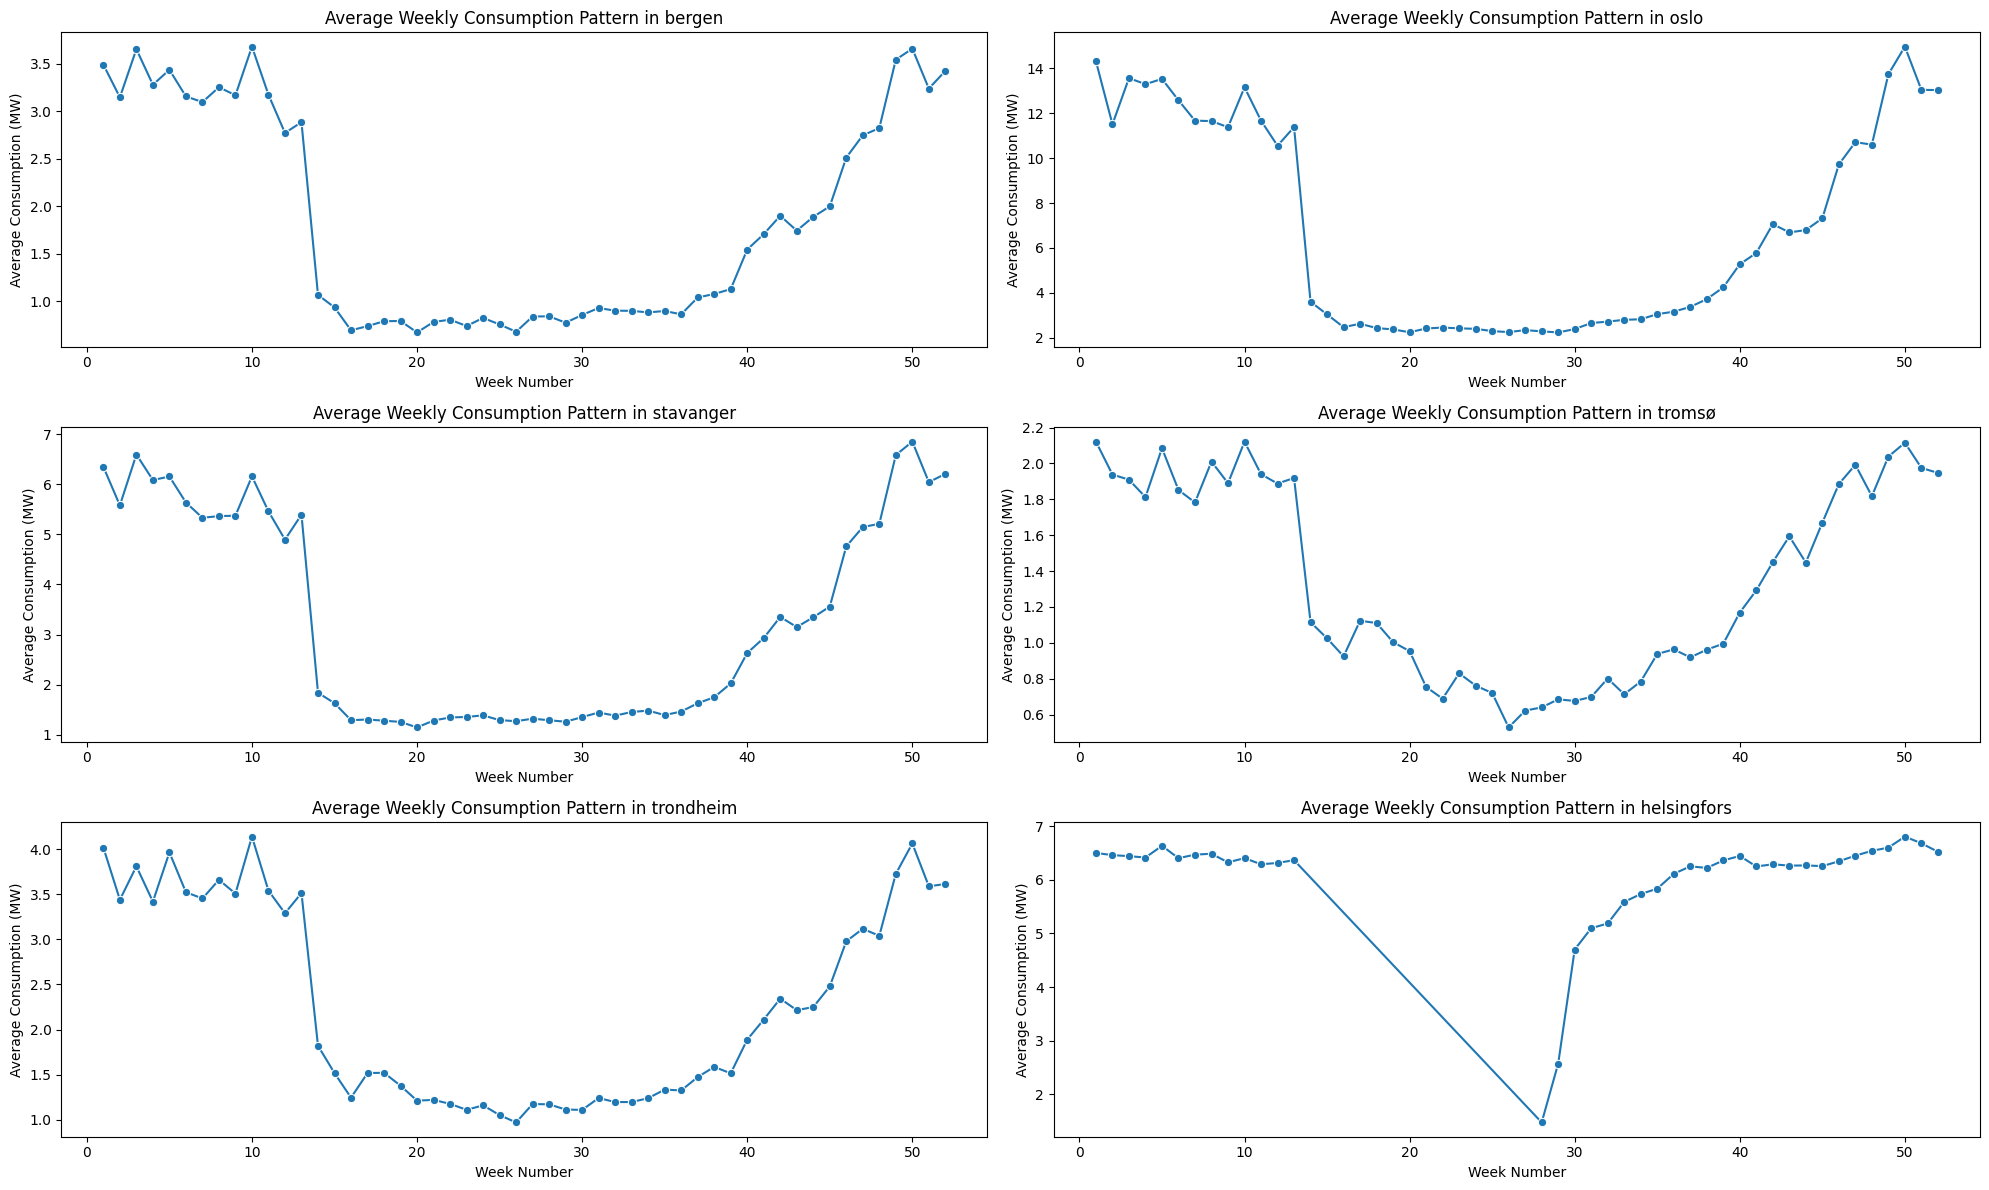

In [7]:
data['week_number'] = data['time'].dt.isocalendar().week
# Calculate the average consumption for each week number for each location
avg_week_consumption = data.groupby(['location', 'week_number'])['consumption'].mean().reset_index()


# Create a new figure for displaying the average consumption for each week number across all locations
plt.figure(figsize=(20, 12))

# Loop through each unique location and plot the average consumption for each week number
for i, location in enumerate(data['location'].unique()):
    

    plt.subplot(3, 2, i+1)
    location_data = avg_week_consumption[avg_week_consumption['location'] == location]
   
    # Convert to appropriate data types
    location_data['week_number'] = location_data['week_number'].astype(int)
    location_data['consumption'] = location_data['consumption'].astype(float)

    sns.lineplot(x='week_number', y='consumption', data=location_data, marker='o')
    plt.title(f'Average Weekly Consumption Pattern in {location}')
    plt.xlabel('Week Number')
    plt.ylabel('Average Consumption (MW)')

plt.tight_layout()
plt.show()


 sarima for oslo
 

{'bergen': 6.06371487158359e-29, 'oslo': 3.3381770090576885e-29, 'stavanger': 9.860205222729471e-29, 'tromsø': 1.9526961941306183e-27, 'trondheim': 1.015266031590186e-27}


c:\Users\johan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\johan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\johan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


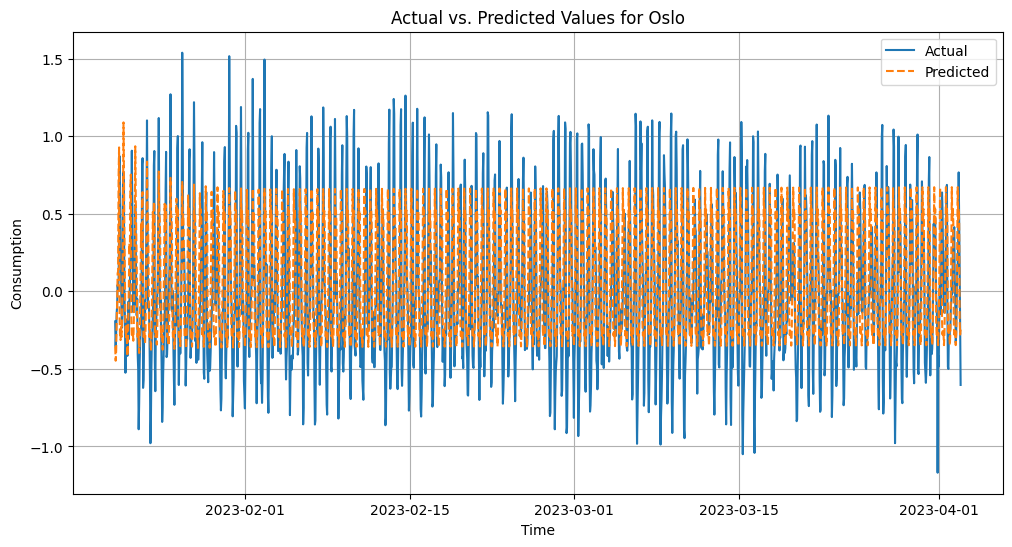

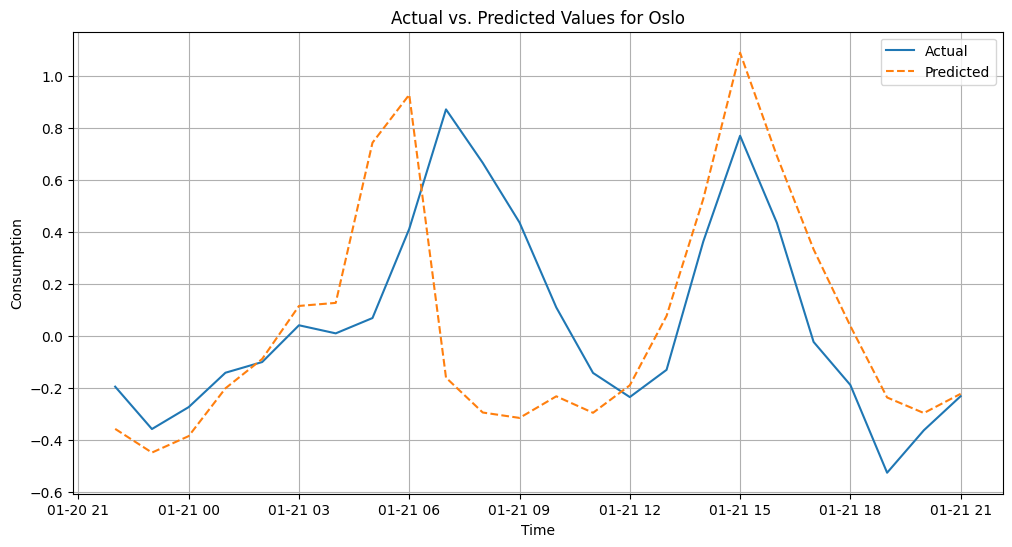

In [8]:


unique_locations = data['location'].unique()
unique_locations

# Initialize an empty dictionary to store the ADF test results for each location
adf_results = {}

# Loop through each unique location and perform the Augmented Dickey-Fuller test
for location in unique_locations:
    location_data = data[data['location'] == location]
    location_data = location_data.set_index('time')
    location_data = location_data.sort_index()
    adf_test = adfuller(location_data['consumption'])
    adf_results[location] = adf_test[1]


# Initialize an empty dictionary to store the new ADF test results after differencing
adf_results_diff = {}

# Loop through each unique location, apply first-order differencing, and perform the ADF test again
for location in unique_locations:
    if adf_results[location] > 0.05:  # Check if the original series was non-stationary
        location_data = data[data['location'] == location]
        location_data = location_data.set_index('time')
        location_data = location_data.sort_index()
        location_data_diff = location_data['consumption'].diff().dropna()
        adf_test_diff = adfuller(location_data_diff)
        adf_results_diff[location] = adf_test_diff[1]

# Display the new ADF test p-values for each location after differencing
print(adf_results_diff)



# Filter data for Oslo
oslo_data = data[data['location'] == 'oslo']
oslo_data = oslo_data.set_index('time')
oslo_data = oslo_data.sort_index()
oslo_data_diff = oslo_data['consumption'].diff().dropna()

# Split data into training and testing sets (80% training, 20% testing)
train_size_oslo = int(len(oslo_data_diff) * 0.8)
train_oslo, test_oslo = oslo_data_diff[0:train_size_oslo], oslo_data_diff[train_size_oslo:]

# Fit the SARIMA model
# Note: Given the limited data, the parameters are set to (1,1,1)(1,1,1,12) for demonstration
model_oslo = SARIMAX(train_oslo, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit_oslo = model_oslo.fit(disp=False)

# Make predictions
predictions_oslo = model_fit_oslo.predict(start=len(train_oslo), end=len(train_oslo) + len(test_oslo) - 1)

# Calculate RMSE (Root Mean Square Error) for Oslo
rmse_oslo = sqrt(mean_squared_error(test_oslo, predictions_oslo))
rmse_oslo


#plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(oslo_data_diff.index[train_size_oslo:], test_oslo, label='Actual', linestyle='-')
plt.plot(oslo_data_diff.index[train_size_oslo:], predictions_oslo, label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Actual vs. Predicted Values for Oslo')
plt.legend()
plt.grid(True)
plt.show()



#plot predicited values for the next 24 hours
plt.figure(figsize=(12, 6))
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+24], test_oslo[:24], label='Actual', linestyle='-')
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+24], predictions_oslo[:24], label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Actual vs. Predicted Values for Oslo')
plt.legend()
plt.grid(True)
plt.show()




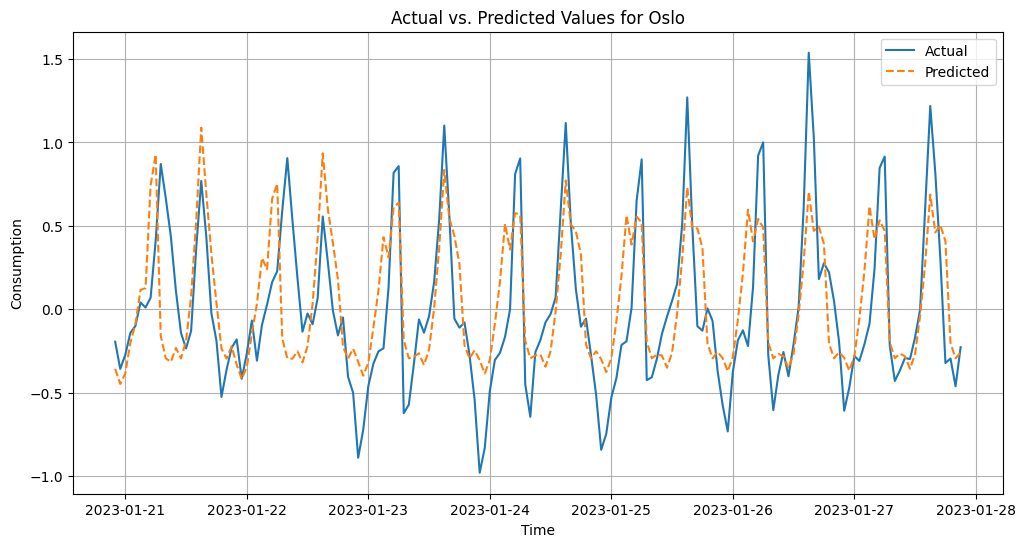

In [9]:
#plot weekly predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+168], test_oslo[:168], label='Actual', linestyle='-')
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+168], predictions_oslo[:168], label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Actual vs. Predicted Values for Oslo')
plt.legend()
plt.grid(True)
plt.show()


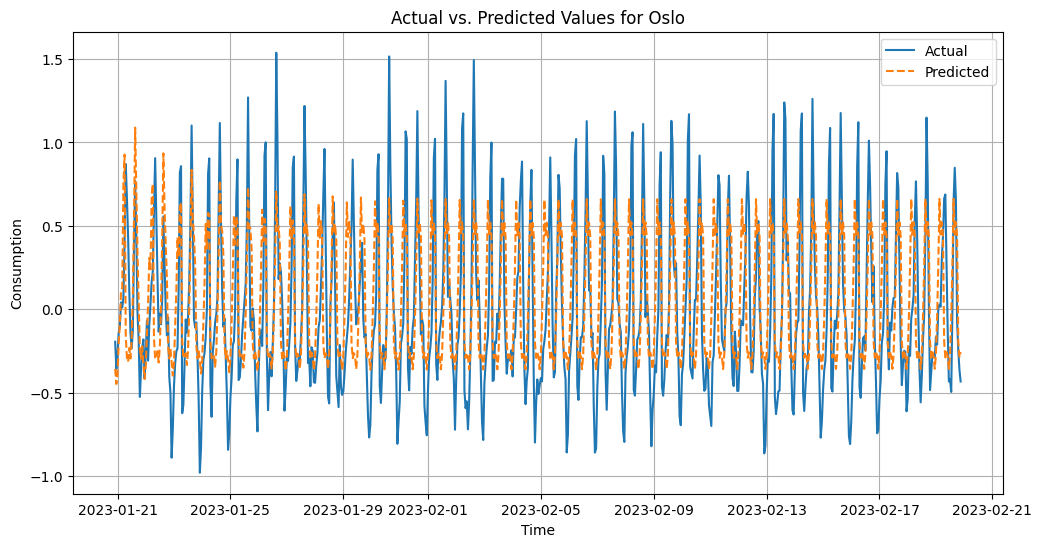

In [10]:
#plot 1 month predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+720], test_oslo[:720], label='Actual', linestyle='-')
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+720], predictions_oslo[:720], label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Actual vs. Predicted Values for Oslo')
plt.legend()
plt.grid(True)
plt.show()


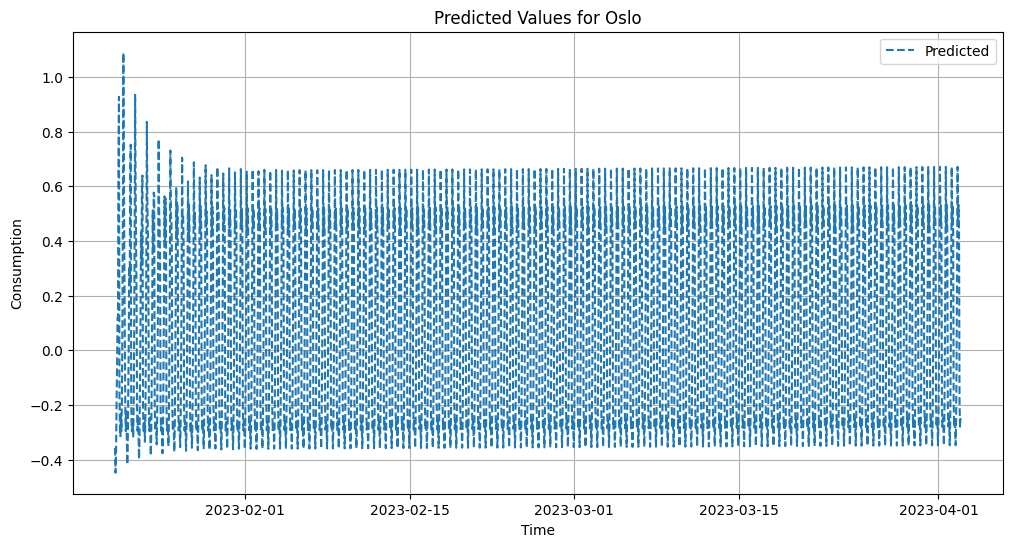

In [11]:
#plot 1 yr of predicted values
plt.figure(figsize=(12, 6))
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+8760], predictions_oslo[:8760], label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Predicted Values for Oslo')
plt.legend()
plt.grid(True)  
plt.show()



ValueError: x and y must have same first dimension, but have shapes (1728,) and (8760,)

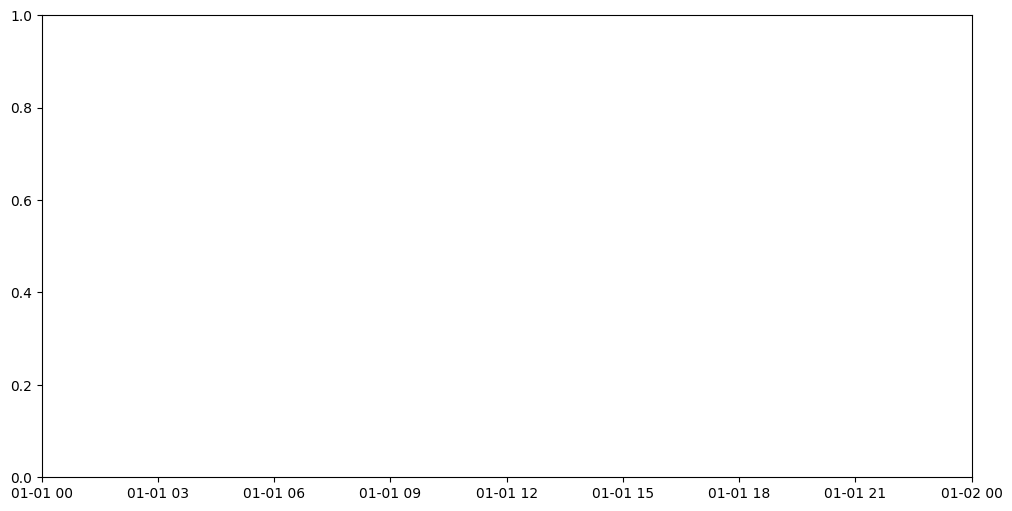

In [12]:
#predict weekly consumption values for 1 year
predictions_oslo_1yr = model_fit_oslo.predict(start=len(train_oslo), end=len(train_oslo) + 8760 - 1)
plt.figure(figsize=(12, 6))
plt.plot(oslo_data_diff.index[train_size_oslo:train_size_oslo+8760], predictions_oslo_1yr[:8760], label='Predicted', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Predicted Values for Oslo')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\johan\AppData\Local\Temp\ipykernel_27292\1150941457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oslo_data['time'] = pd.to_datetime(oslo_data['time'])


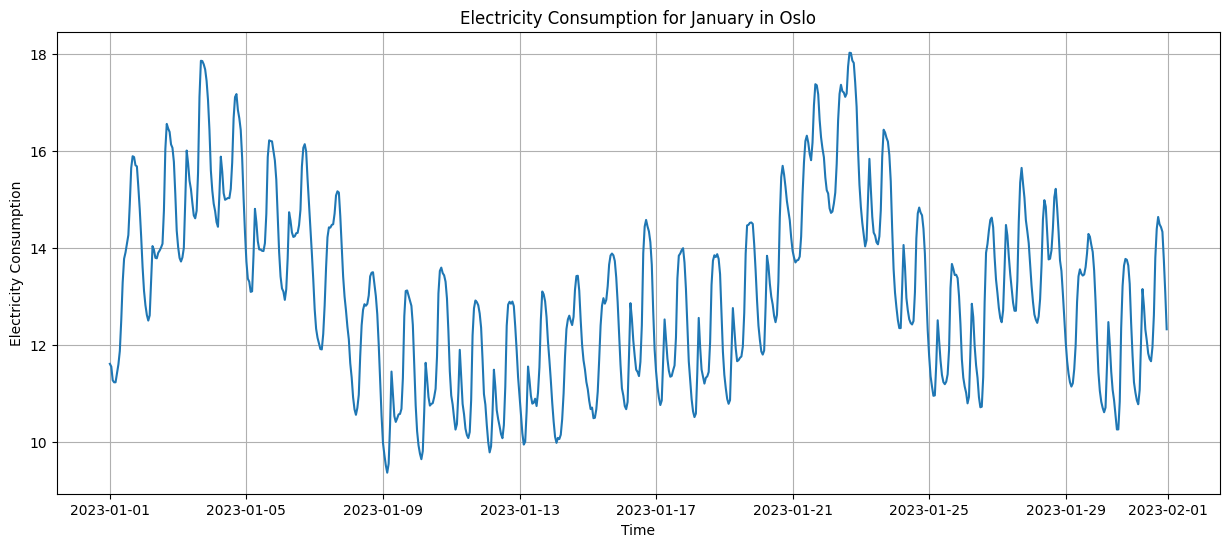

In [ ]:
# Filter the data to include only records from Oslo and convert the 'time' column to datetime format
oslo_data = data[data['location'] == 'oslo']
oslo_data['time'] = pd.to_datetime(oslo_data['time'])

# Filter the data to include only records from January (assuming the data is from 2022, as seen in the sample)
oslo_january_data = oslo_data[oslo_data['time'].dt.month == 1]

# Plot the electricity consumption for January in Oslo
plt.figure(figsize=(15, 6))
plt.plot(oslo_january_data['time'], oslo_january_data['consumption'])
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption for January in Oslo')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import warnings

# Define the parameter grid
p = d = q = range(0, 3)  # Define the p, d, and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q))

# Seasonal parameters
P = D = Q = range(0, 2)  # Seasonal parameters can take value between 0 and 1
s = [12]  # Seasonal periodicity, 12 stands for yearly seasonality
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(P, D, Q, s))]

# Suppress warnings
warnings.filterwarnings("ignore")

best_aic = float("inf")
best_params = None
best_seasonal_params = None

# Grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_oslo,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()

            # Check if the current model is better than the previous best model
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

# Print the best parameters
print(f"The best model has parameters: order={best_params} seasonal_order={best_seasonal_params} with AIC={best_aic}")
